# ML foodtech Refund Classifier

<h1> О проекте </h1>
Этот проект - исследование предиктивной аналитики с использованием ML моделей для предсказания вероятности возврата товара доставки в сфере e-commerce fooodtech

<p>Основная цель заключается в исследовании зависимости различных парамтров (время, день, сутки, город, стоимость и т.д) на запрос возврата <i>любой суммы</i> </p>

<h1> О датасете </h1>

Название: Call Center Restaurant Orders Dataset
датасет включает записи данных нескольких ресторанов и их формленных заказов с курьерской доставкой.

Количество строк: 72,314
Количество стоблцов: 17

    Date - Дата оформления заказа клиентом
    Time customer placed order - Время оформления заказа
    Time order placed at restaurant - Время, когда ресторан получил заказ
    Time driver arrived at restaurant - Время, когда курьер прбыл в ресторан и забрал заказ
    Delivery time - Время доставки еды клиенту
    Driver ID - ID курьера
    Driver Name - Имя курьера
    Restaurant ID - ID ресторана
    Customer ID - ID клиента
    Delivery Area - Города Калифорнии: Fremont, Hayward and Union city, где была зарегестрирована доставка
    ASAP - категориальная пометка клиета "As Soon As Possible" - "Как можно скорее"
    Sub Total - Стоимость заказа
    Delivery Fee - Оплаченные клиентом пошлины доставки
    Service Fee - Оплаченные пошлины за сервис
    Discount - Скидка, если была применена
    Tip - количество чаевых, оставленные клиентом
    Refunded amount - Стоимость запроса на возврат по желнию клиента, отказу в о оплате

<h2> Ссылка на gitHub проект EDA анализа датасета:</h2>

[EDA analys](https://github.com/RenitaBlessina/Food_Delivery-and-Customer_Behaviour-Analysis)

<h2> Ссылка на датасет:<h2>

[Dataset source link](https://fp20analytics.com/datasets)


# Начало работы

In [144]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 

from datetime import datetime, timedelta

from scipy.stats import mannwhitneyu, chi2_contingency, ttest_ind
from statsmodels.stats.proportion import proportion_confint

from sklearn.cluster import KMeans

In [145]:
delivery_data =pd.read_csv("restaurant-orders.csv")

In [146]:
delivery_data.columns

Index(['Date', 'Time customer placed order', 'Time order placed at restaurant',
       'Time driver arrived at restaurant', 'Delivery time', 'Driver ID',
       'Driver Name', 'Restaurant ID', 'Customer ID', 'Delivery Area', 'ASAP',
       'Sub Total', 'Delivery fee', 'Service fee', 'Discount', 'Tip',
       'Refunded amount'],
      dtype='object')

In [147]:
#Просмотр количества всех пропусков по данным
delivery_data.isna().sum()

Date                                     0
Time customer placed order               0
Time order placed at restaurant        160
Time driver arrived at restaurant    18124
Delivery time                            0
Driver ID                                0
Driver Name                              0
Restaurant ID                            0
Customer ID                              0
Delivery Area                            0
ASAP                                     0
Sub Total                                0
Delivery fee                             0
Service fee                              0
Discount                                 0
Tip                                      0
Refunded amount                          0
dtype: int64

In [148]:
delivery_data.head()

,Date,Time customer placed order,Time order placed at restaurant,Time driver arrived at restaurant,Delivery time,Driver ID,Driver Name,Restaurant ID,Customer ID,Delivery Area,ASAP,Sub Total,Delivery fee,Service fee,Discount,Tip,Refunded amount
0,2020-01-01,02:52:12,03:00:25,03:08:09,03:35:20,9329,Christy,7263,1143515,Fremont,Yes,$21.39,$0.43,$3.83,$2.00,$1.40,$0.00
1,2020-01-01,15:58:57,17:56:45,18:24:39,18:57:01,9175,Elizabeth,7247,1136820,Hayward,Yes,$99.74,$6.05,$2.30,$2.00,$11.03,$0.00
2,2020-01-01,19:02:37,19:12:51,19:19:59,19:31:09,9051,Janet,7293,1081871,Hayward,Yes,$21.97,$2.74,$2.39,$8.00,$4.31,$0.00
3,2020-01-01,04:01:57,04:08:18,04:13:02,04:37:57,9389,Jacquelyn,7046,1128255,Union City,Yes,$32.79,$0.12,$2.55,$2.00,$8.55,$0.00
4,2020-01-01,23:46:38,23:49:32,23:54:29,00:37:15,9187,Lauren,7385,1051183,Hayward,Yes,$67.56,$3.77,$3.35,$2.00,$8.82,$0.00


# Предобработка данных

In [149]:
delivery_data = delivery_data.rename(columns={
    "Time customer placed order":"time_ordered",
    "Time order placed at restaurant":"time_placed",
    "Time driver arrived at restaurant":"time_arrived",
    "Delivery time":"time_delivered",
    "Driver ID":"driver_id",
    "Driver Name":"driver_name",
    "Restaurant ID":"restaurant_id",
    "Customer ID":"customer_id",
    "Delivery Area":"delivery_area",
    "Sub Total":"sub_total",
    "Delivery fee":"delivery_fee",
    "Service fee":"service_fee",
    "Discount":"discount",
    "Tip":"tip",
    "Refunded amount":"refund"
})

In [150]:
#ML модель основывается на данных для пользователя, колонки водителей и ресторанов излишни
delivery_data = delivery_data.drop(["driver_name","restaurant_id","driver_id"],axis=1)

#Время готовки позиции в ресторане и время приезда курьера в него можно опустить (кроме того данные содержат пропуски)
delivery_data = delivery_data.drop(["time_placed","time_arrived"], axis = 1)


In [151]:
def get_normal_price(refund):
    """получить цену без $"""
    refund = refund[1:]
    return float(refund)

In [152]:
#Преобразовать цены
delivery_data["refund"] = delivery_data.refund.astype(str).apply(lambda x: get_normal_price(x))
delivery_data["tip"] = delivery_data.tip.astype(str).apply(lambda x: get_normal_price(x))
delivery_data["discount"] = delivery_data.discount.astype(str).apply(lambda x: get_normal_price(x))
delivery_data["service_fee"] = delivery_data.service_fee.astype(str).apply(lambda x: get_normal_price(x))
delivery_data["delivery_fee"] = delivery_data.delivery_fee.astype(str).apply(lambda x: get_normal_price(x))

#есть формат цены 1,000.14
delivery_data["sub_total"] = delivery_data.sub_total.str.replace(",","")
delivery_data["sub_total"] = delivery_data.sub_total.astype(str).apply(lambda x: get_normal_price(x))

In [153]:
delivery_data.head()

,Date,time_ordered,time_delivered,customer_id,delivery_area,ASAP,sub_total,delivery_fee,service_fee,discount,tip,refund
0,2020-01-01,02:52:12,03:35:20,1143515,Fremont,Yes,21.39,0.43,3.83,2.0,1.40,0.0
1,2020-01-01,15:58:57,18:57:01,1136820,Hayward,Yes,99.74,6.05,2.30,2.0,11.03,0.0
2,2020-01-01,19:02:37,19:31:09,1081871,Hayward,Yes,21.97,2.74,2.39,8.0,4.31,0.0
3,2020-01-01,04:01:57,04:37:57,1128255,Union City,Yes,32.79,0.12,2.55,2.0,8.55,0.0
4,2020-01-01,23:46:38,00:37:15,1051183,Hayward,Yes,67.56,3.77,3.35,2.0,8.82,0.0


## Калькуляция времени доставки

In [154]:
#преобразовываем строковое время в удобный формат времени
time_ordered = delivery_data.time_ordered.apply(lambda x: datetime.strptime(x,"%H:%M:%S"))
time_delivered = delivery_data.time_delivered.apply(lambda x: datetime.strptime(x,"%H:%M:%S"))

time_delta_df = pd.DataFrame({"time_ordered":time_ordered,
                              "time_delivered":time_delivered})

In [155]:
def get_delivery_minutes(t_ordered, t_delivered):
    # Если время доставки меньше времени заказа, значит, доставка на следующий день
    if t_delivered < t_ordered:
        t_delivered += timedelta(days=1)  # Добавляем 1 день
    
    delta = t_delivered - t_ordered
    return round(delta.total_seconds() / 60, 2)

def get_delivery_time(row):
    dt_ordered = row["time_ordered"]
    dt_delivered = row["time_delivered"]
    return get_delivery_minutes(dt_ordered,dt_delivered)

In [156]:
#общее время доставки
delivery_time = time_delta_df.apply(get_delivery_time, axis=1)

delivery_data["delivery_time"] = delivery_time

In [157]:
delivery_data.head()

,Date,time_ordered,time_delivered,customer_id,delivery_area,ASAP,sub_total,delivery_fee,service_fee,discount,tip,refund,delivery_time
0,2020-01-01,02:52:12,03:35:20,1143515,Fremont,Yes,21.39,0.43,3.83,2.0,1.40,0.0,43.13
1,2020-01-01,15:58:57,18:57:01,1136820,Hayward,Yes,99.74,6.05,2.30,2.0,11.03,0.0,178.07
2,2020-01-01,19:02:37,19:31:09,1081871,Hayward,Yes,21.97,2.74,2.39,8.0,4.31,0.0,28.53
3,2020-01-01,04:01:57,04:37:57,1128255,Union City,Yes,32.79,0.12,2.55,2.0,8.55,0.0,36.00
4,2020-01-01,23:46:38,00:37:15,1051183,Hayward,Yes,67.56,3.77,3.35,2.0,8.82,0.0,50.62


## Вычисляем день недели
Распределим даты по дням (понедельник, вторник, среда и т.д)

In [158]:
days = pd.to_datetime(delivery_data.Date)

delivery_data["Date"] = days.dt.day_name()

In [159]:
delivery_data.head()

,Date,time_ordered,time_delivered,customer_id,delivery_area,ASAP,sub_total,delivery_fee,service_fee,discount,tip,refund,delivery_time
0,Wednesday,02:52:12,03:35:20,1143515,Fremont,Yes,21.39,0.43,3.83,2.0,1.40,0.0,43.13
1,Wednesday,15:58:57,18:57:01,1136820,Hayward,Yes,99.74,6.05,2.30,2.0,11.03,0.0,178.07
2,Wednesday,19:02:37,19:31:09,1081871,Hayward,Yes,21.97,2.74,2.39,8.0,4.31,0.0,28.53
3,Wednesday,04:01:57,04:37:57,1128255,Union City,Yes,32.79,0.12,2.55,2.0,8.55,0.0,36.00
4,Wednesday,23:46:38,00:37:15,1051183,Hayward,Yes,67.56,3.77,3.35,2.0,8.82,0.0,50.62


# Анализ распределений

## Распределение классов

In [160]:
refunds = delivery_data[delivery_data.refund>0].customer_id.count()
non_refunds = delivery_data[delivery_data.refund==0].customer_id.count()

print(f"Количество возратов: {refunds}")
print(f"Количество оформленных заказов: {non_refunds}")
print(f"В процентном соотношении: {refunds / (non_refunds+refunds) *100:.2f}%")

Количество возратов: 1984
Количество оформленных заказов: 70330
В процентном соотношении: 2.74%


Классы неуравновешены, необходимо работать с методами для несбалансированных классов (кросс-валидация, уравновешивание весов)

### Распределение классов по дням недели

In [161]:
date_table = (
    delivery_data
    .assign(refund=lambda x: x['refund'] > 0)
    .pivot_table(
        index="refund",
        values="customer_id",
        columns="Date",
        aggfunc="count",
        fill_value=0
    )
    .reset_index()
)
date_table

Date,refund,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,False,8822,9850,10617,10514,10462,8911,11154
1,True,229,284,282,324,310,251,304


## Время доставки

<Axes: xlabel='delivery_time', ylabel='Density'>

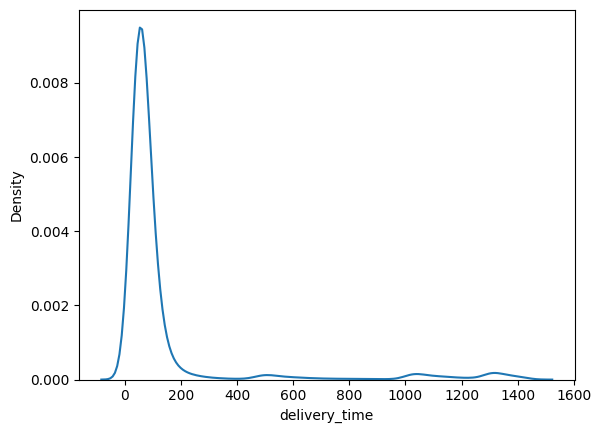

In [162]:
sns.kdeplot(delivery_data,x="delivery_time")

Данные delivery_time содержат большое количество выбросов. Распределение смещено к левому краю, образовав "тяжелый хвост" на экстремальных значениях

## Цена доставки

<Axes: xlabel='sub_total', ylabel='Density'>

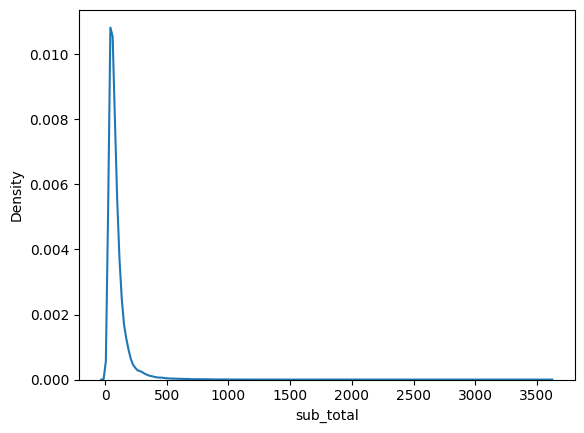

In [163]:
sns.kdeplot(delivery_data,x="sub_total")

### Аномалия

При анализе были установлены некоторые нулевые значения цены

In [164]:
print(f"Количество таких наблюдений: {delivery_data[delivery_data.sub_total==0].customer_id.count()}")

Количество таких наблюдений: 8


In [165]:
delivery_data[delivery_data.sub_total==0].head()

,Date,time_ordered,time_delivered,customer_id,delivery_area,ASAP,sub_total,delivery_fee,service_fee,discount,tip,refund,delivery_time
3935,Tuesday,00:00:29,01:06:04,1166937,Hayward,Yes,0.0,7.09,3.62,2.0,0.0,83.59,65.58
12800,Wednesday,00:06:33,00:47:00,1048629,Hayward,Yes,0.0,1.19,3.12,2.0,0.0,0.00,40.45
19653,Monday,23:37:06,00:04:04,1065646,Fremont,Yes,0.0,1.62,4.28,3.0,0.0,0.00,26.97
26851,Saturday,04:19:45,04:49:46,1002074,Union City,Yes,0.0,9.71,4.95,3.0,0.0,114.52,30.02
44056,Friday,03:06:27,04:12:08,1155551,Fremont,Yes,0.0,1.79,4.71,2.0,0.0,0.00,65.68


Возможные причины такого поведения цены включают ошибки транзакций, ошибки со стороны базы данных. Возможно это даже некоторая мошенническая махинация или системная уязвимость, в любом случае наблюдения любопытны и будут устранены

<Axes: xlabel='sub_total', ylabel='Density'>

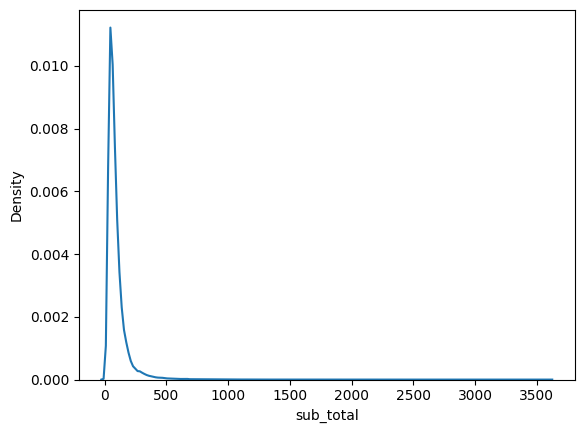

In [166]:
#устранение аномалий
delivery_data = delivery_data[delivery_data.sub_total!=0]
sns.kdeplot(delivery_data,x="sub_total")

Ситуация схожа с delivery_time, но хвост более выражен

## Побочные ценовые компоненты

<Axes: xlabel='delivery_fee', ylabel='Density'>

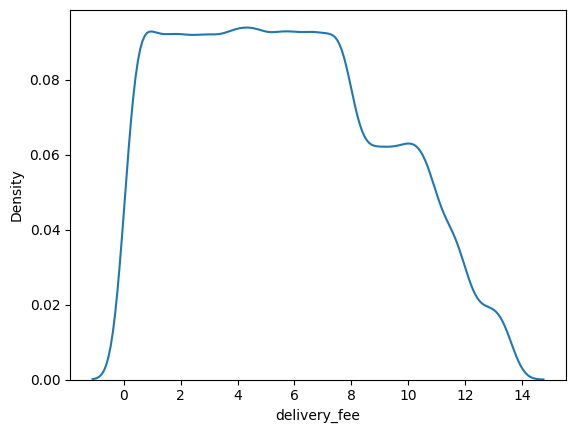

In [167]:
sns.kdeplot(delivery_data,x="delivery_fee")

В распределении отсуствуют выбросы, но имеется выраженное отклонение от нормального

<Axes: xlabel='service_fee', ylabel='Density'>

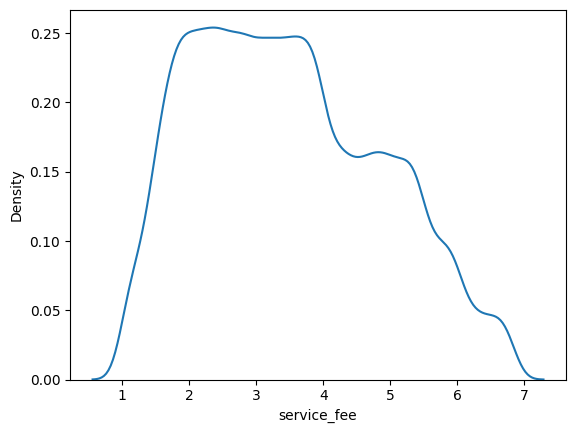

In [168]:
sns.kdeplot(delivery_data,x="service_fee")

Схожая ситуация с распределением выше

<Axes: xlabel='discount', ylabel='Density'>

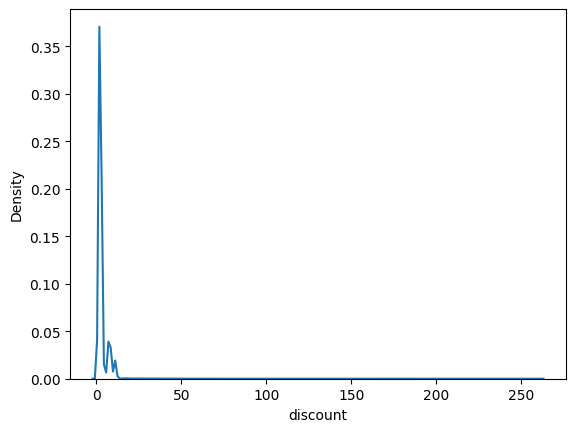

In [169]:
sns.kdeplot(delivery_data,x="discount")

Распределение не унимодально и имеет тяжелый хвост

<Axes: xlabel='tip', ylabel='Density'>

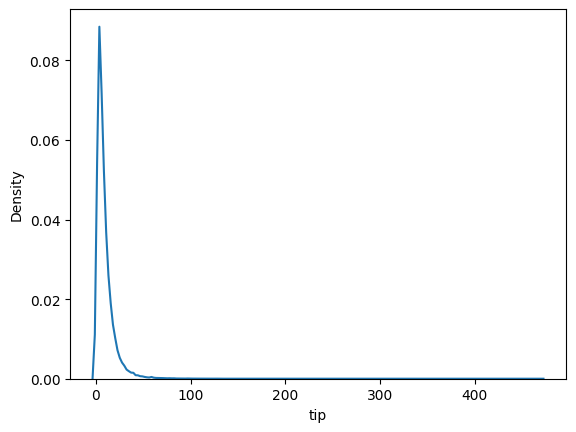

In [170]:
sns.kdeplot(delivery_data,x="tip")

Распределение чаевых похоже на нормальное, но так же страдает от выбросов

## Распределение по дням недели

<Axes: xlabel='Date', ylabel='count'>

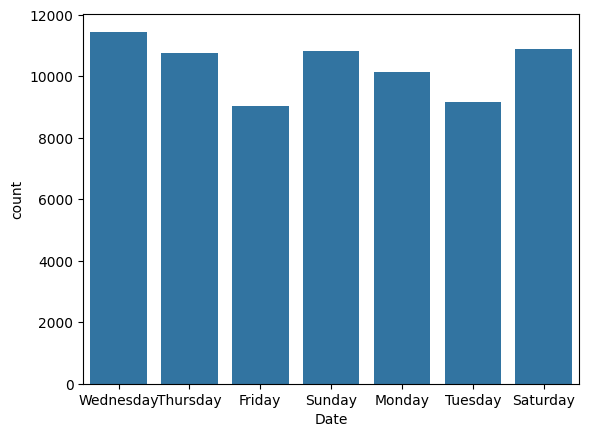

In [171]:
sns.countplot(delivery_data,x="Date")

Распределение по дням выглядит нормлальным

# Устранение выбросов

## Выбросы веремени доставки

<Axes: xlabel='delivery_time', ylabel='Density'>

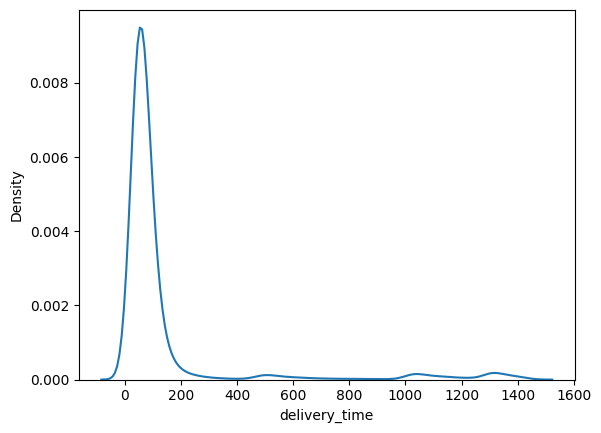

In [172]:
sns.kdeplot(delivery_data,x="delivery_time")

<Axes: xlabel='delivery_time', ylabel='Density'>

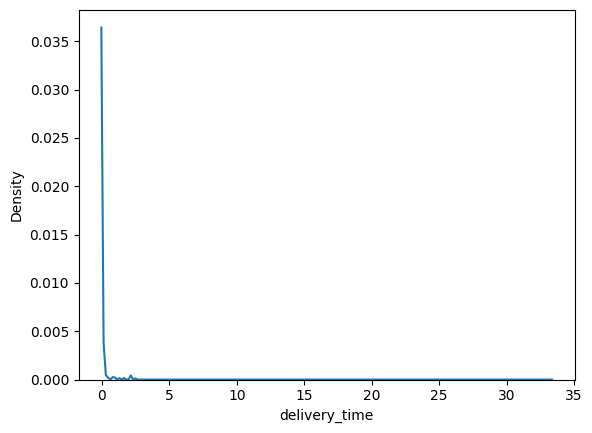

In [173]:
#нормализируем цену товара через обратное преобразлование
normalized_delivery = 1 / delivery_data.delivery_time
sns.kdeplot(normalized_delivery)

In [174]:
print(f"99-й персептиль: {normalized_delivery.quantile(0.99):.6f}")

#сметим все значения к 99-ому пернсептилю
normalized_delivery = normalized_delivery.clip(upper = normalized_delivery.quantile(0.99))

99-й персептиль: 0.041288


<Axes: xlabel='delivery_time', ylabel='Density'>

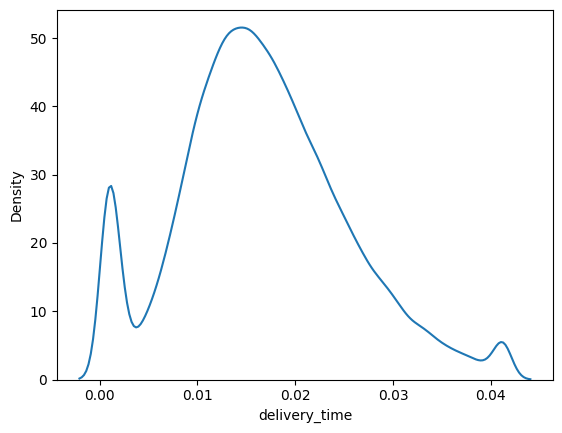

In [175]:
sns.kdeplot(normalized_delivery)

Из-за "сжатия" обратным преобразованием, в распределении были убраны выбросы, ценой создания новой моды и усложнения интерпретации модели

Распределим моды по факторам, соотвествющие времении доставки: очень долгое, долгое, среднее (Из-за обратной операции, чтение времени идет наоборот)

In [176]:
delivery_data["delivery_time"] = normalized_delivery

bin =[0, 0.0016, 0.002, 1]  #подобрано через опущенную визуализацию
labels = ["extra_long", "long", "normal"]
delivery_data["delivery"] = pd.cut(delivery_data["delivery_time"],bins=bin,labels=labels)

<Axes: xlabel='delivery_time', ylabel='Density'>

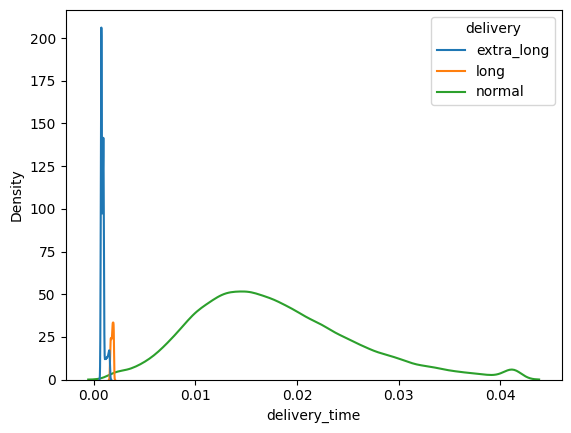

In [177]:
sns.kdeplot(delivery_data, x="delivery_time",hue="delivery")

Просмотрим ближе распределения крайних случаев

<Axes: xlabel='delivery_time', ylabel='Density'>

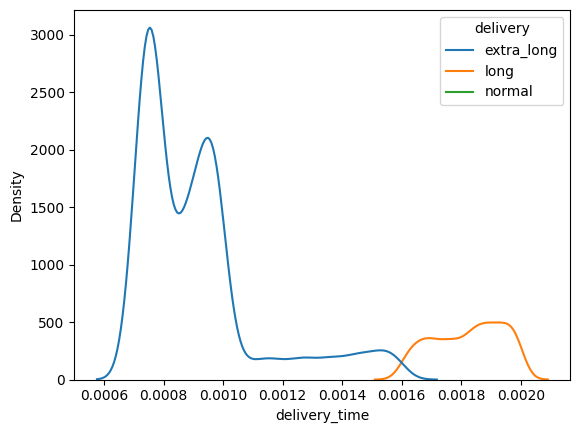

In [178]:
sns.kdeplot(delivery_data[(delivery_data.delivery =="extra_long") | (delivery_data.delivery == "long")], x= "delivery_time", hue="delivery")

Распределения все еще сложно считать нормальным, однако теперь эти случаи категоризированы

Расрпределение "долгих" доставок поближе

<Axes: xlabel='delivery_time', ylabel='Density'>

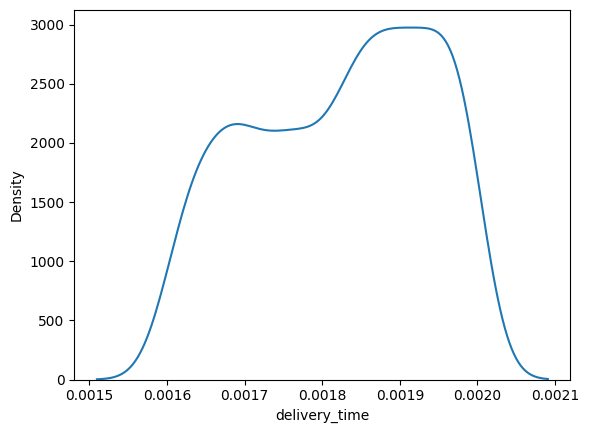

In [179]:
sns.kdeplot(delivery_data[(delivery_data.delivery =="long")], x= "delivery_time")

## Выбросы цены

Для цены товара снова используем обратную конвертацию

In [180]:
delivery_data["sub_total"] = 1 / delivery_data.sub_total

In [181]:
print(f"99-й персенптиль обратной стоимости товара: {delivery_data.sub_total.quantile(0.99):.2f}")\

threshold = delivery_data.sub_total.quantile(0.99)
# delivery_data = delivery_data[delivery_data.sub_total <=threshold]

delivery_data["sub_total"] = delivery_data["sub_total"].clip(upper=threshold)

99-й персенптиль обратной стоимости товара: 0.05


<Axes: xlabel='sub_total', ylabel='Density'>

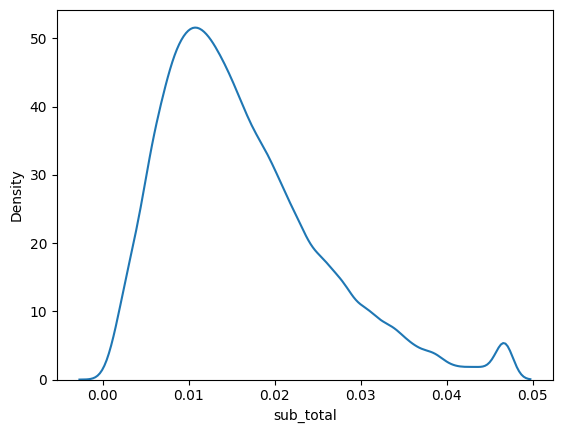

In [182]:
sns.kdeplot(delivery_data,x="sub_total")

Будем считать получившееся распределение приемлимым для использования

## Выбросы скидок и чаевых

In [183]:
#заменим ценовой discount на экивалент % от стоимости 
delivery_data["discount"] = (delivery_data.discount / (1/delivery_data.sub_total)) *100

#тоже самое с tip
delivery_data["tip"] = (delivery_data.tip / (1/delivery_data.sub_total) )*100

<Axes: xlabel='discount', ylabel='Density'>

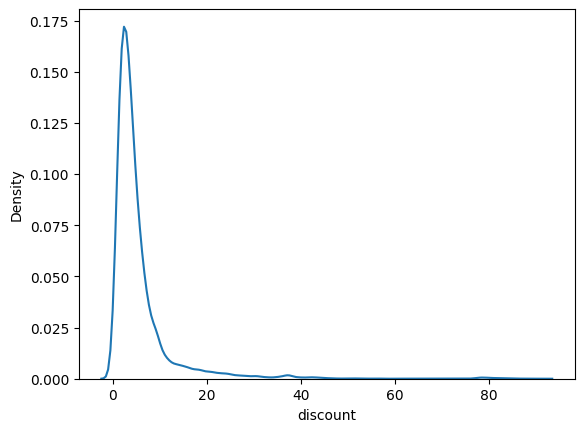

In [184]:
sns.kdeplot(delivery_data,x="discount")

In [185]:
print(f"Максимальная скидка из данных: {delivery_data.discount.max():.2f}")

Максимальная скидка из данных: 91.02


In [186]:
bins = [0,5,10,20,50,92]
labels = ['0-5%', '5-10%', '10-20%', '20-50%', '50-92%']
delivery_data["discount"] = pd.cut(delivery_data.discount,bins=bins,labels=labels)

Для устранения выбросов был выбран биллинг, так как абсолютный прирост скидки малозначим и сложен для интерпретирования бизнесом

<Axes: xlabel='discount', ylabel='count'>

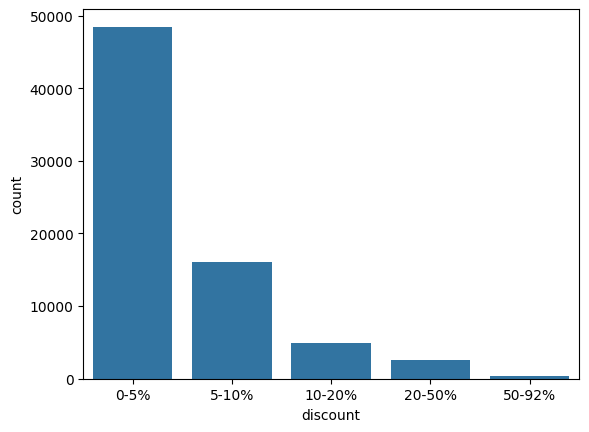

In [187]:
sns.countplot(delivery_data,x="discount")

<Axes: xlabel='tip', ylabel='Density'>

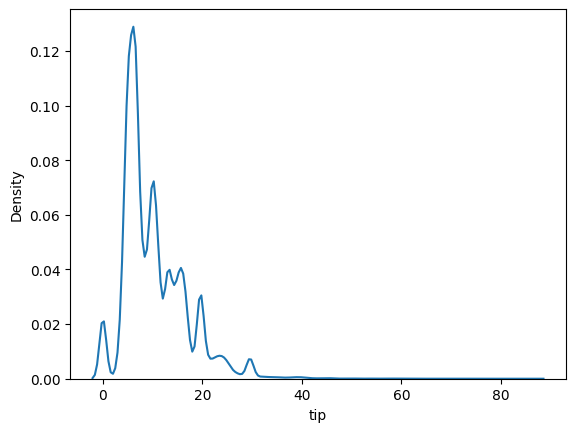

In [188]:
sns.kdeplot(delivery_data,x="tip")

In [189]:
print(f"Максимальные чаевые из данных: {delivery_data.tip.max():.2f}")

Максимальные чаевые из данных: 86.49


In [190]:
bins = [0,5,10,20,50,90]
labels = ['0-5%', '5-10%', '10-20%', '20-50%', '50-90%']
delivery_data["tip"] = pd.cut(delivery_data.tip,bins=bins,labels=labels)

<Axes: xlabel='tip', ylabel='count'>

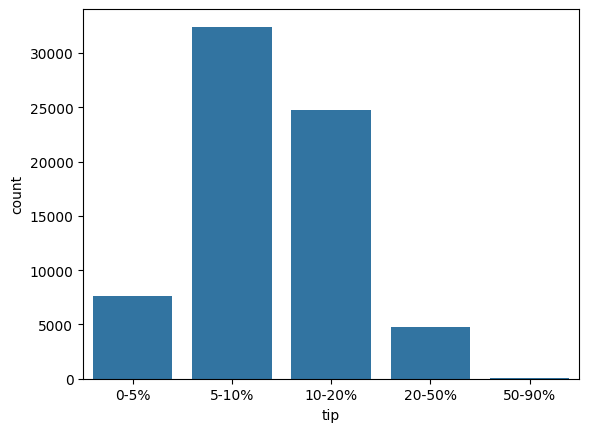

In [191]:
sns.countplot(delivery_data,x="tip")

# Замена классифицируемой переменной на фактор
Исследуется факт возврата, а не вероятное количество возращаемой суммы.

In [192]:
delivery_data["refund"] = delivery_data.refund >0

# updated EDA Анализ взаимодействий переменных

## Скидки

<Axes: xlabel='discount', ylabel='count'>

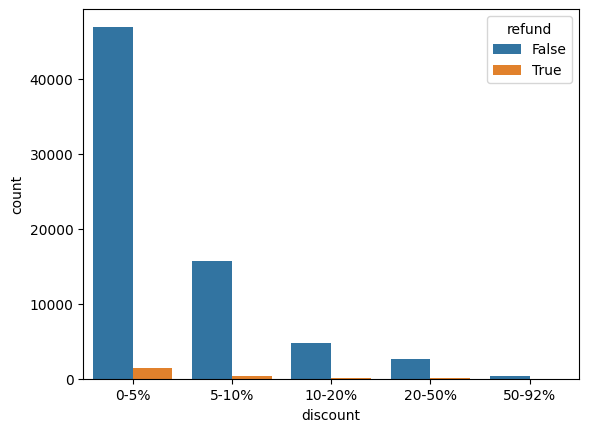

In [193]:
sns.countplot(delivery_data,x="discount",hue="refund")

### Рассмотрим поближе экстремальные случаи

<Axes: xlabel='discount', ylabel='count'>

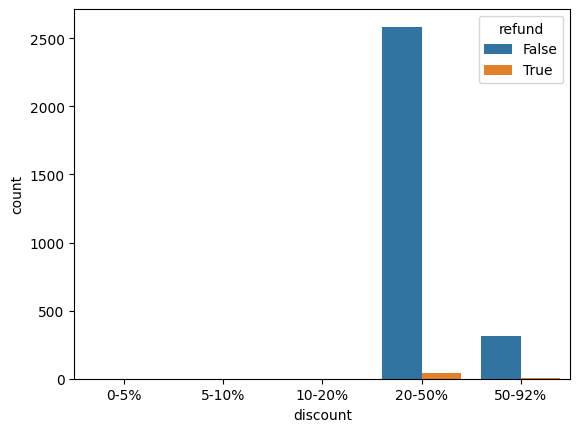

In [194]:
sns.countplot(delivery_data[(delivery_data.discount=="20-50%") | (delivery_data.discount=="50-92%")],x="discount",hue="refund")

Из визуализации невозможно получить точные даынные, требуется более глубокий анализ

## Сторонние фаторы цены

<Axes: xlabel='delivery_fee', ylabel='sub_total'>

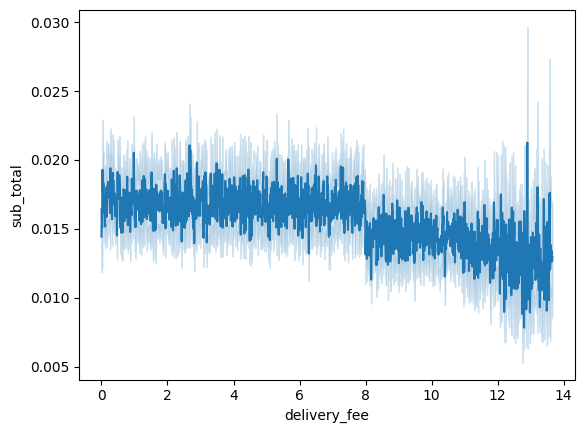

In [195]:
sns.lineplot(delivery_data,x="delivery_fee", y="sub_total")

<Axes: xlabel='service_fee', ylabel='sub_total'>

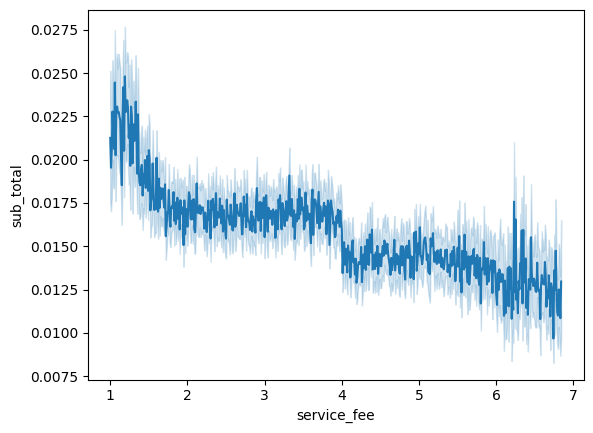

In [196]:
sns.lineplot(delivery_data,x="service_fee",y="sub_total")

Service_fee может иметь потенциальную корреляцию с ценой товара (причем корреляция логически правильно интерпретируется)

### Корреляция с возвратом

<Axes: xlabel='service_fee'>

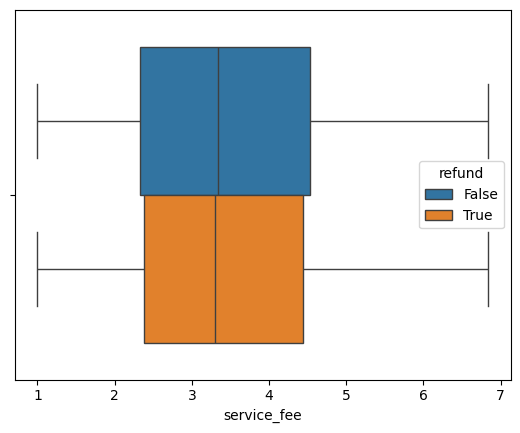

In [197]:
sns.boxplot(delivery_data, x="service_fee", hue="refund")

<Axes: xlabel='refund', ylabel='service_fee'>

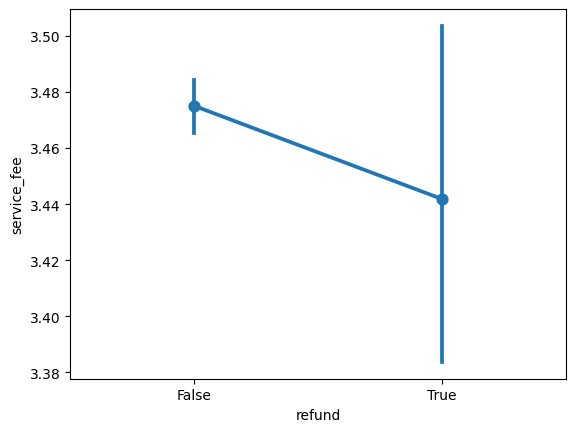

In [198]:
sns.pointplot(delivery_data, y="service_fee", x="refund")

<Axes: xlabel='delivery_fee'>

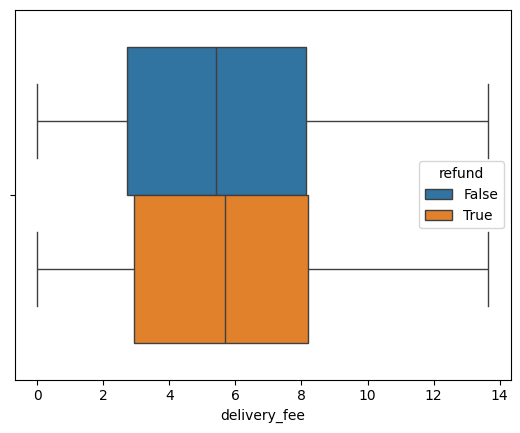

In [199]:
sns.boxplot(delivery_data, x="delivery_fee", hue="refund")

<Axes: xlabel='refund', ylabel='delivery_fee'>

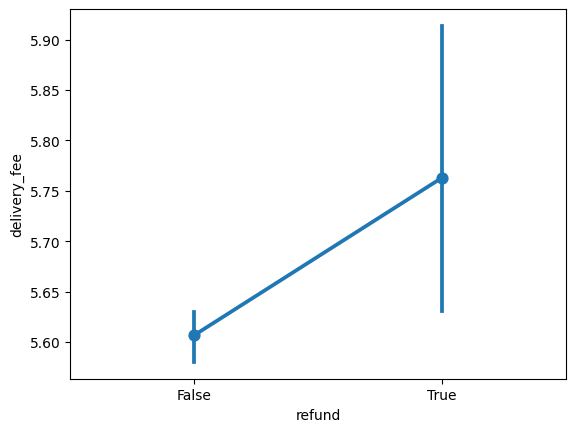

In [200]:
sns.pointplot(delivery_data, y="delivery_fee", x="refund")

Даже если различия статистически значимы, смещение медиан в обоих случаях настолько незначительное, что не имеет практической значимости.
Кроме того, переменная стоимости сервиса имеет возможную корреляцию со стоимостью.
Было решено объединить эти параметры для улучшения модели

## Время доставки

<Axes: xlabel='delivery_time'>

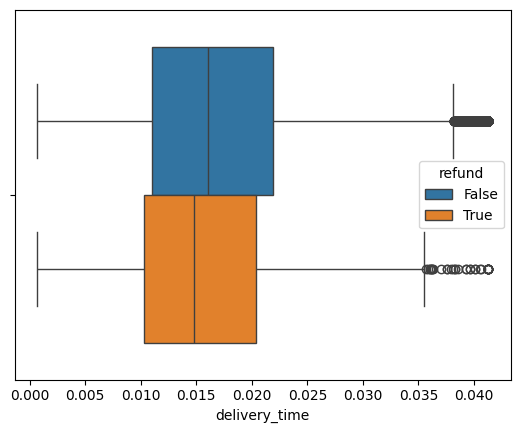

In [201]:
sns.boxplot(delivery_data,x = "delivery_time", hue="refund")

<Axes: xlabel='refund', ylabel='delivery_time'>

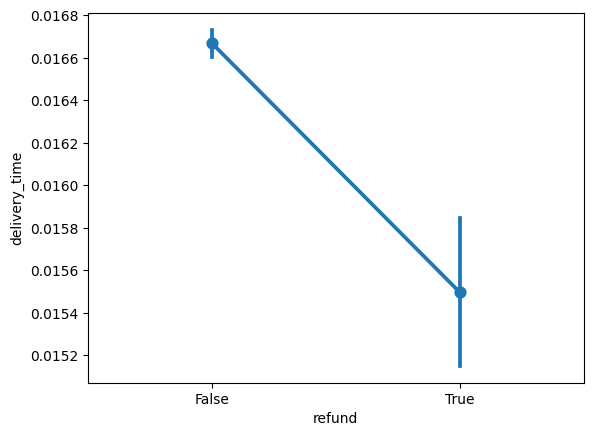

In [202]:
sns.pointplot(delivery_data,x="refund",y="delivery_time")

<Axes: xlabel='ASAP', ylabel='delivery_time'>

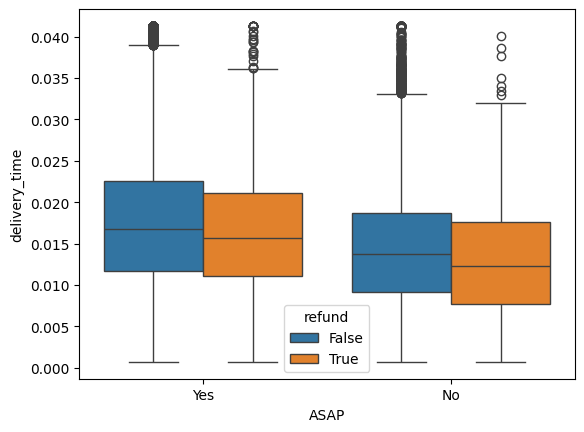

In [203]:
sns.boxplot(delivery_data, x="ASAP",y="delivery_time", hue="refund")

<Axes: xlabel='refund', ylabel='delivery_time'>

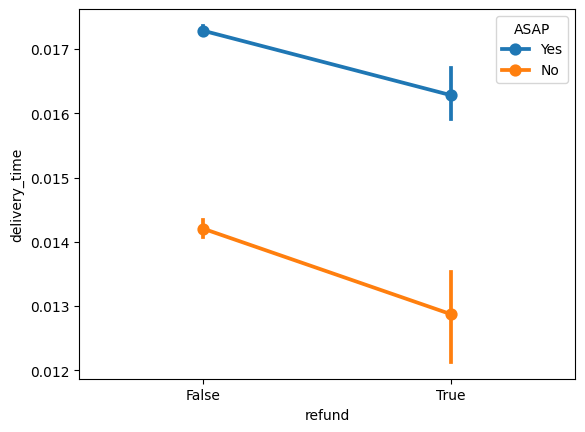

In [204]:
sns.pointplot(delivery_data,x="refund",y="delivery_time", hue = "ASAP")

Из визуализации явно видна взаимосвязь времени доставки с другими переменными. Требует углубленного анализа

## Чаевые

<Axes: xlabel='tip', ylabel='count'>

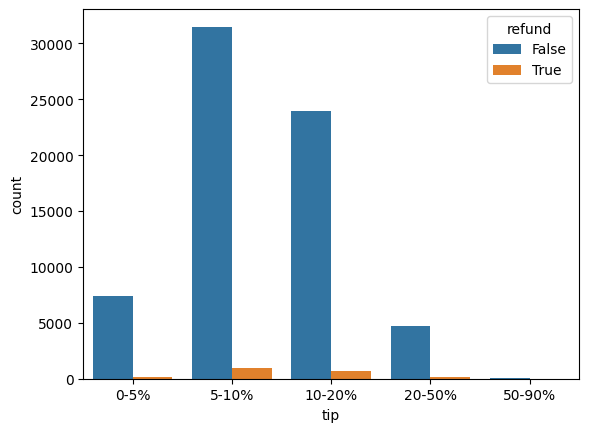

In [205]:
sns.countplot(delivery_data,x="tip",hue="refund")

На визуализации количество возвратов примерно сопосоставимо с общим количеством заказов в категориях. Визуализация не дает должного анализа

## Дни недели

<Axes: xlabel='Date', ylabel='count'>

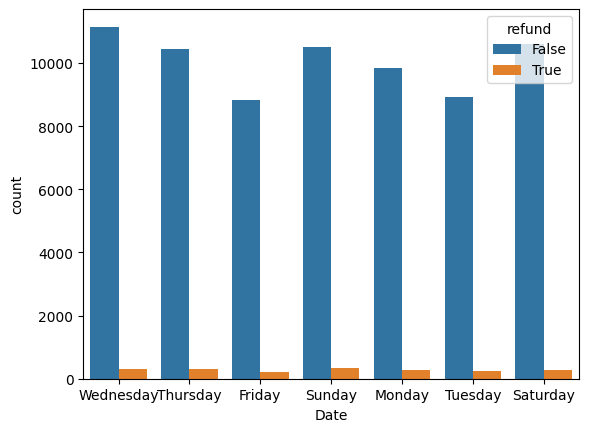

In [206]:
sns.countplot(delivery_data,x="Date",hue="refund")

Количество рапспределено примерно равномерно. Может говорить об отсутствии потенциальной связи между переменными

# Feature engineering

## Объединяем цены

In [207]:
#объединяем цены
delivery_data["sub_total"] = (1 / 
                              ((1/ delivery_data.sub_total) + delivery_data.delivery_fee + delivery_data.service_fee))

#старые переменные уже не нужны
delivery_data = delivery_data.drop(["delivery_fee","service_fee"],axis=1)

<Axes: xlabel='sub_total', ylabel='Density'>

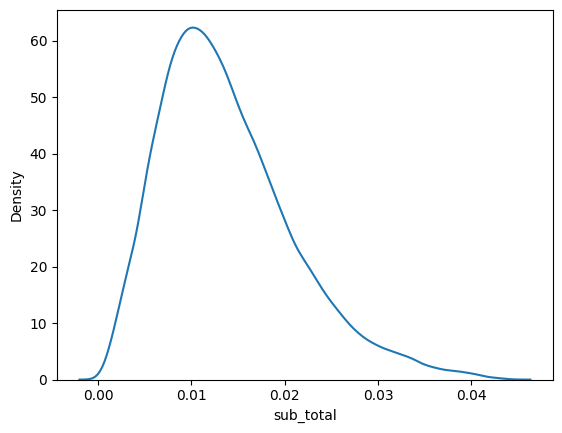

In [208]:
sns.kdeplot(delivery_data, x="sub_total")

## Распределение по времени заказа
Распределим время как утро, день, вечер, ночь

In [209]:
# ночь (00:00:00 - 04:59:59)
# утро (05:00:00 - 09:59:59)
# день (10:00:00 - 16:59:59)
# вечер (17:00:00 - 21:59:59)
# ночь (22:00:00 - 23:59:59)

labels = ["ночь", "утро", "день", "вечер", "ночь"]

# Преобразуем время в секунды
time_delivered_seconds =(
    time_delivered.dt.hour * 3600 +
    time_delivered.dt.minute *60 +
    time_delivered.dt.second
)

time_ordered_seconds =(
    time_ordered.dt.hour * 3600 +
    time_ordered.dt.minute *60 +
    time_ordered.dt.second
)

delivery_data["time_delivered"] = pd.cut(time_delivered_seconds,
        bins =[0,5*3600, 10*3600, 17*3600, 22*3600, 24*3600], 
        labels=labels, ordered = False)

delivery_data["time_ordered"] = pd.cut(time_ordered_seconds,
        bins =[0,5*3600, 10*3600, 17*3600, 22*3600, 24*3600], 
        labels=labels, ordered = False)

In [210]:
delivery_data.head()

,Date,time_ordered,time_delivered,customer_id,delivery_area,ASAP,sub_total,discount,tip,refund,delivery_time,delivery
0,Wednesday,ночь,ночь,1143515,Fremont,Yes,0.038986,5-10%,5-10%,False,0.023186,normal
1,Wednesday,день,вечер,1136820,Hayward,Yes,0.009252,0-5%,10-20%,False,0.005616,normal
2,Wednesday,вечер,вечер,1081871,Hayward,Yes,0.036900,20-50%,10-20%,False,0.035051,normal
3,Wednesday,ночь,ночь,1128255,Union City,Yes,0.028201,5-10%,20-50%,False,0.027778,normal
4,Wednesday,ночь,ночь,1051183,Hayward,Yes,0.013390,0-5%,10-20%,False,0.019755,normal


# Final EDA

## Зависимость дня недели и возврата

<Axes: ylabel='refund'>

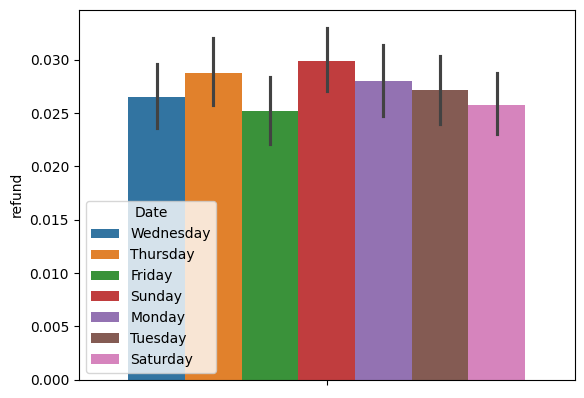

In [211]:
sns.barplot(delivery_data,hue="Date", y="refund")

In [212]:
date_refund_table = pd.crosstab(delivery_data.Date, delivery_data.refund)

In [213]:
print(f"Уровень p-value Хи-квадрат теста: {chi2_contingency(date_refund_table).pvalue:.2f}")

Уровень p-value Хи-квадрат теста: 0.37


Данные оказались статистически не значимы

Вероятность возврата скорее всего не зависит от дня оформления заказа

## Промежуток времени оформления заказа и возврат

### Время заказа позиции

<Axes: xlabel='time_ordered', ylabel='count'>

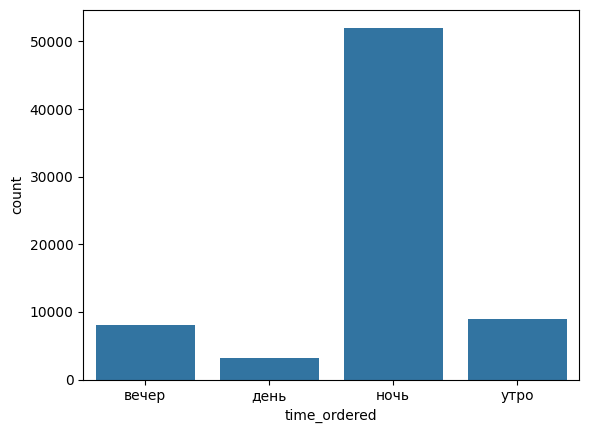

In [214]:
sns.countplot(delivery_data,x="time_ordered")

<Axes: ylabel='refund'>

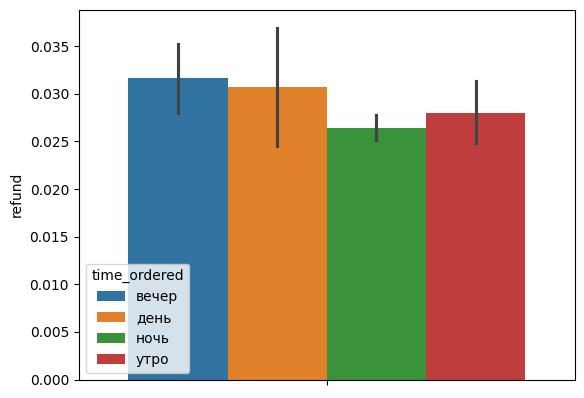

In [215]:
sns.barplot(delivery_data,y="refund", hue="time_ordered")

In [216]:
cross_tab = pd.crosstab(delivery_data.time_ordered,delivery_data.refund)
cross_tab

refund,False,True
time_ordered,,
вечер,7868,257
день,3121,99
ночь,50664,1374
утро,8669,250


In [217]:
print(f"Уровень p-value Хи-квадрат теста: {chi2_contingency(cross_tab).pvalue:.2f}")

Уровень p-value Хи-квадрат теста: 0.03


In [218]:
#получить процентное количество рефандов на промежуток времени заказа
percent_refund_distribution = cross_tab[True] / (cross_tab[False] + cross_tab[True]) * 100
print("Распределение случаев рефанда относительно:", percent_refund_distribution)

print("Распределение случаев рефанда относительно среднего распределения:", percent_refund_distribution - percent_refund_distribution.mean())

Распределение случаев рефанда относительно: time_ordered
вечер    3.163077
день     3.074534
ночь     2.640378
утро     2.803005
dtype: float64
Распределение случаев рефанда относительно среднего распределения: time_ordered
вечер    0.242828
день     0.154286
ночь    -0.279870
утро    -0.117244
dtype: float64


Анализ времени заказа дал статистическую значимость. Распределение отклонений от среднего групп незначительно, но моежт быть полезно в условии дисбалансировки классов

Возможность возврата может зависеть от времени оформления заказа (утро, день, вечер, ночь)

### Время приезда заказа клиенту

<Axes: xlabel='time_delivered', ylabel='count'>

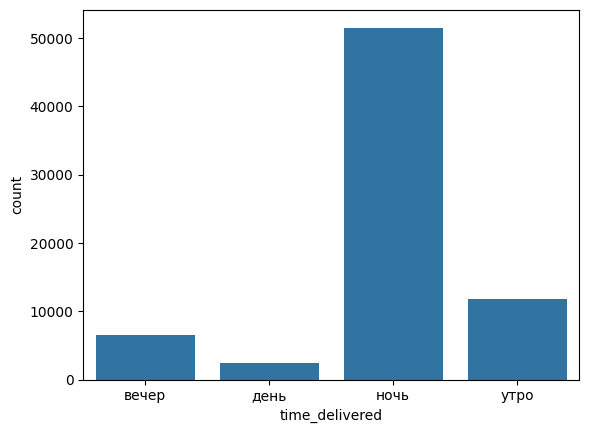

In [219]:
sns.countplot(delivery_data,x="time_delivered")

<Axes: ylabel='refund'>

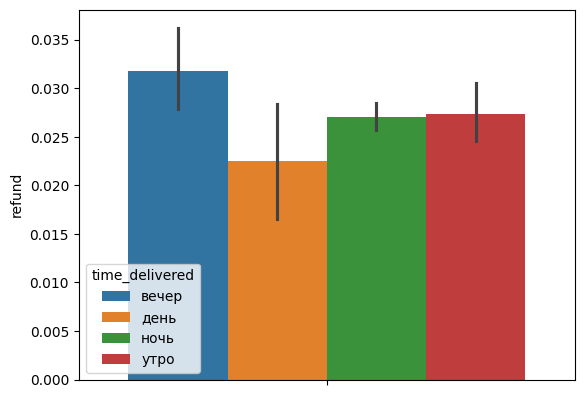

In [220]:
sns.barplot(delivery_data,y="refund",hue="time_delivered")

In [221]:
cross_tab = pd.crosstab(delivery_data.time_delivered, delivery_data.refund)
cross_tab

refund,False,True
time_delivered,,
вечер,6325,208
день,2305,53
ночь,50162,1394
утро,11534,325


In [222]:
print(f"Уровень p-value Хи-квадрат теста: {chi2_contingency(cross_tab).pvalue:.2f}")

Уровень p-value Хи-квадрат теста: 0.06


In [223]:
#получить процентное количество рефандов на промежуток времени заказа
percent_refund_distribution = cross_tab[True] / (cross_tab[False] + cross_tab[True]) * 100
print("Распределение случаев рефанда относительно:", percent_refund_distribution)

print("Распределение случаев рефанда относительно среднего распределения:", percent_refund_distribution - percent_refund_distribution.mean())

Распределение случаев рефанда относительно: time_delivered
вечер    3.183836
день     2.247668
ночь     2.703856
утро     2.740535
dtype: float64
Распределение случаев рефанда относительно среднего распределения: time_delivered
вечер    0.464862
день    -0.471306
ночь    -0.015118
утро     0.021561
dtype: float64


Зависимость времени доставки заказа клоиенту можно назвать значимым. Кроме того, оно дает более мощные отклонения от среднего по группам

Возможность возврата может зависеть от времени приезда курьера (утро, день, вечер, ночь)

## Место проведения доставок

<Axes: ylabel='refund'>

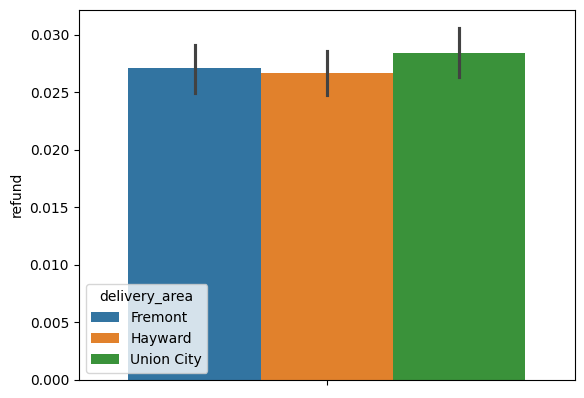

In [224]:
sns.barplot(delivery_data,y="refund",hue="delivery_area")

In [225]:
pd.crosstab(delivery_data.delivery_area, delivery_data.refund)

refund,False,True
delivery_area,,
Fremont,23571,656
Hayward,23439,643
Union City,23316,681


In [226]:
print(f"Уровень p-value Хи-квадрат теста: {chi2_contingency(pd.crosstab(delivery_data.delivery_area, delivery_data.refund)).pvalue:.2f}")

Уровень p-value Хи-квадрат теста: 0.50


Место проведения доставок не дал статистической значимости по имеющимся городам.
Города находятся в пределах одного штата, что может дать недостаточные данные для анализа.

На текущих данных место проведения доставки не влияет на возврат

## As Soon As Possible показатель

<Axes: xlabel='ASAP', ylabel='refund'>

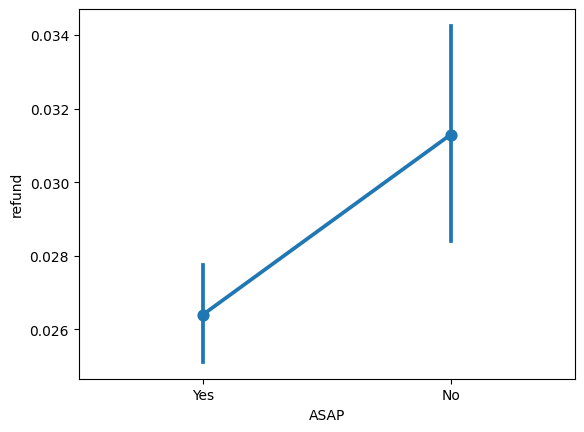

In [227]:
sns.pointplot(delivery_data,y="refund",x="ASAP")

In [228]:
cross_tab = pd.crosstab(delivery_data.ASAP,delivery_data.refund)
cross_tab

refund,False,True
ASAP,,
No,14115,456
Yes,56211,1524


In [229]:
print(f"Уровень p-value Хи-квадрат теста: {chi2_contingency(cross_tab).pvalue:.2f}")

Уровень p-value Хи-квадрат теста: 0.00


In [230]:
proportions = delivery_data.groupby("ASAP")["refund"].mean()
print(f"Средний процент возврата в группе ASAP '{proportions.index[0]}': {proportions.iloc[0]:.3f}")

print(f"Средний процент возврата в группе ASAP '{proportions.index[1]}': {proportions.iloc[1]:.3f}")

print(f"Относительный риск между первой и 2-й группами: '{proportions.index[0]}': {proportions.iloc[0] / proportions.iloc[1]:.3f} ({((proportions.iloc[0] / proportions.iloc[1])-1)*100:.3f}%)")

Средний процент возврата в группе ASAP 'No': 0.031
Средний процент возврата в группе ASAP 'Yes': 0.026
Относительный риск между первой и 2-й группами: 'No': 1.186 (18.558%)


Практическая значимость объясняется тем, что при факторе ASAP "No" вероятность возврата на 13% больше, чем с ASAP "Yes".
Вероятно причиной является взаимодействие факторов времени и требует дополнительного 

Пожелание коиента доставить товар поскорее может иметь практическую ценность для модели

#### Взаимодействие с временем доставки

<Axes: xlabel='ASAP', ylabel='delivery_time'>

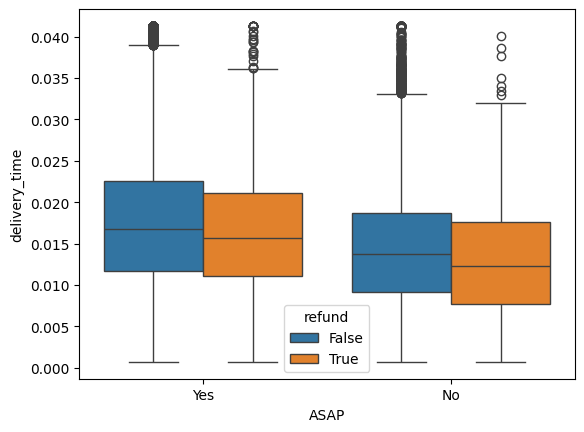

In [231]:
sns.boxplot(delivery_data, y="delivery_time",x="ASAP",hue="refund")

In [232]:
time_table = 1 / delivery_data.groupby(["refund","ASAP"]).delivery_time.mean()
print(f"Разница среднего времени в группе ASAP NO: {time_table.iloc[2] - time_table.iloc[0]:.2f}")
print(f"Разница среднего времени в группе ASAP YES: {time_table.iloc[3] - time_table.iloc[1]:.2f}")
time_table

Разница среднего времени в группе ASAP NO: 7.29
Разница среднего времени в группе ASAP YES: 3.57


refund  ASAP
False   No      70.397742
        Yes     57.849118
True    No      77.687968
        Yes     61.420100
Name: delivery_time, dtype: float64

Хоть разница и статистически значима, практическая ценность взаимодействия фактора ASAP и времени доставки сомнительно (+- 4$)

## Цена товара

<Axes: ylabel='sub_total'>

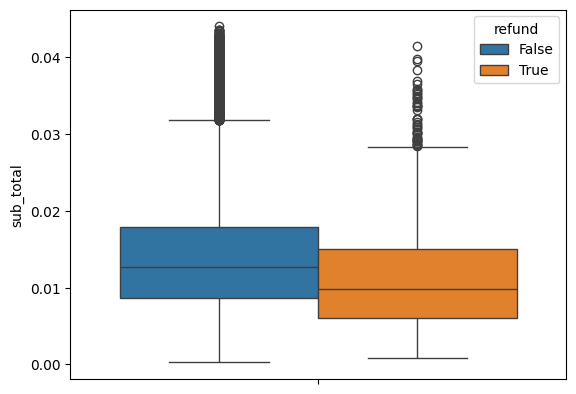

In [233]:
sns.boxplot(delivery_data, y="sub_total", hue="refund")

<Axes: xlabel='refund', ylabel='sub_total'>

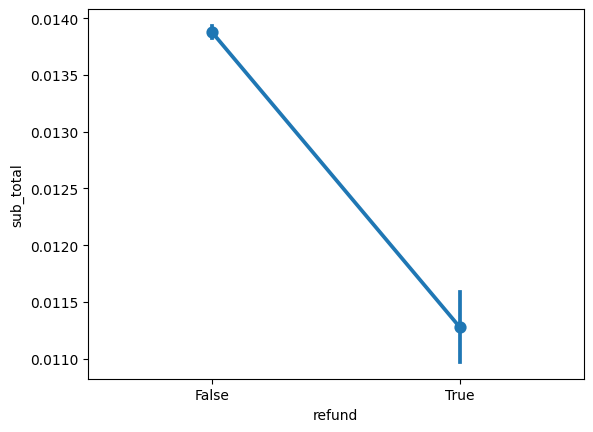

In [234]:
sns.pointplot(delivery_data, y="sub_total",x="refund")

In [235]:
print(f"p-value теста манауитни {mannwhitneyu(delivery_data.sub_total,delivery_data.refund).pvalue:.2f}")

p-value теста манауитни 0.00


In [236]:
print(f"Средня цена товара  датасете: {1 / delivery_data.sub_total.mean():.2f}$")
1 / delivery_data.groupby("refund")["sub_total"].describe().drop(["count","min","max","std"],axis=1)

Средня цена товара  датасете: 72.42$


,mean,25%,50%,75%
refund,,,,
False,72.045998,115.817500,78.750000,55.82
True,88.677047,165.079984,101.349952,66.65


Хоть цена и имеет слабую среднюю разницу (+- 10$), квартили распределения значительно различаются, что может дать потенциальный результат.

## Скидка

<Axes: ylabel='refund'>

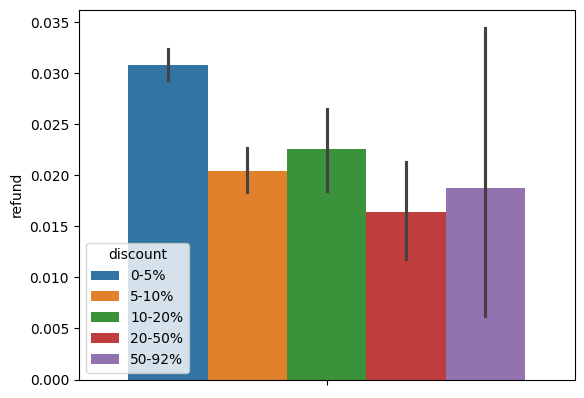

In [237]:
sns.barplot(delivery_data,y="refund",hue="discount")

In [238]:
cross_tab = pd.crosstab(delivery_data.discount,delivery_data.refund)
cross_tab

refund,False,True
discount,,
0-5%,46974,1493
5-10%,15697,328
10-20%,4756,110
20-50%,2585,43
50-92%,313,6


In [239]:
print(f"p-value Хи квадрат для переменных: {chi2_contingency(cross_tab).pvalue:.2f}")

p-value Хи квадрат для переменных: 0.00


In [240]:
#получить процентное количество рефандов на скидку
percent_refund_distribution = cross_tab[True] / (cross_tab[False] + cross_tab[True]) * 100
print("Распределение случаев рефанда относительно:", percent_refund_distribution)

print("Распределение случаев рефанда относительно среднего распределения:", percent_refund_distribution - percent_refund_distribution.mean())

Распределение случаев рефанда относительно: discount
0-5%      3.080446
5-10%     2.046802
10-20%    2.260584
20-50%    1.636225
50-92%    1.880878
dtype: float64
Распределение случаев рефанда относительно среднего распределения: discount
0-5%      0.899459
5-10%    -0.134185
10-20%    0.079597
20-50%   -0.544762
50-92%   -0.300109
dtype: float64


Анализ показывает хороший уровень значимости и отклонений.
Вероятность возврата может зависеть от скидки

## Чаевые

<Axes: ylabel='refund'>

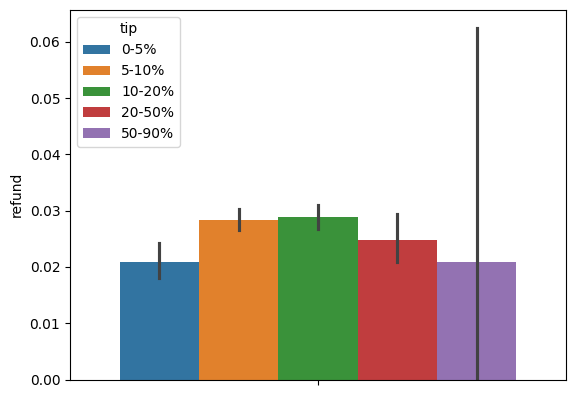

In [241]:
sns.barplot(delivery_data,y="refund",hue="tip")

<Axes: xlabel='tip', ylabel='refund'>

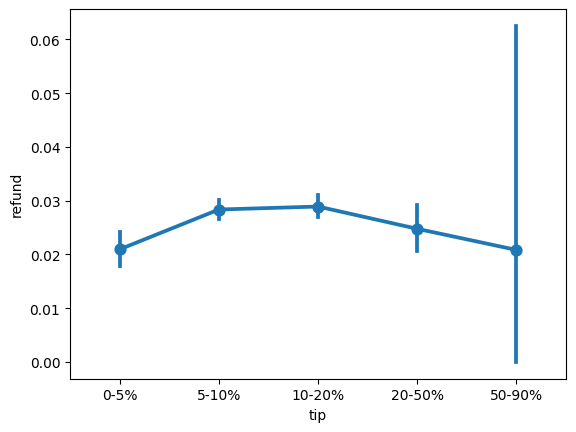

In [242]:
sns.pointplot(delivery_data, y="refund", x="tip")

In [243]:
cross_tab = pd.crosstab(delivery_data.tip, delivery_data.refund)
cross_tab

refund,False,True
tip,,
0-5%,7435,159
5-10%,31499,919
10-20%,23989,714
20-50%,4687,119
50-90%,47,1


In [244]:
print(f"p-value Хи-квадрат теста: {chi2_contingency(cross_tab).pvalue:.2f}")

p-value Хи-квадрат теста: 0.00


In [245]:
#получить процентное количество рефандов на чай
percent_refund_distribution = cross_tab[True] / (cross_tab[False] + cross_tab[True]) * 100
print("Распределение случаев рефанда относительно:", percent_refund_distribution)

print("Распределение случаев рефанда относительно среднего распределения:", percent_refund_distribution - percent_refund_distribution.mean())

Распределение случаев рефанда относительно: tip
0-5%      2.093758
5-10%     2.834845
10-20%    2.890337
20-50%    2.476072
50-90%    2.083333
dtype: float64
Распределение случаев рефанда относительно среднего распределения: tip
0-5%     -0.381911
5-10%     0.359176
10-20%    0.414668
20-50%    0.000403
50-90%   -0.392336
dtype: float64


Чаевые являются статистически и практически допустимыми (относительно других параметров) для формирования гипотезы о влиянии

## Время доставки

<Axes: ylabel='delivery_time'>

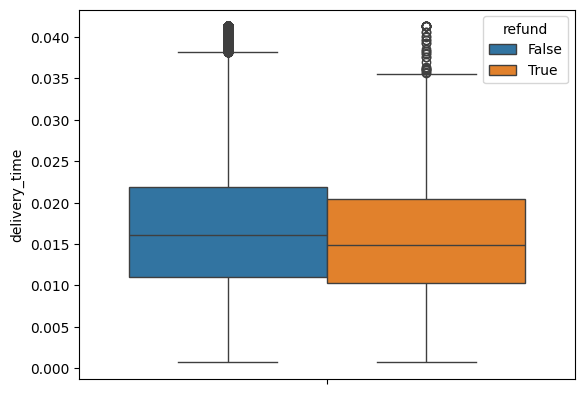

In [246]:
sns.boxplot(delivery_data,y="delivery_time",hue="refund")

<Axes: xlabel='refund', ylabel='delivery_time'>

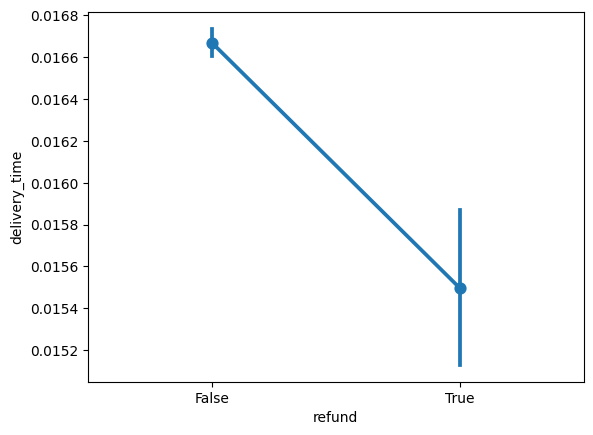

In [247]:
sns.pointplot(delivery_data,x="refund",y="delivery_time")

In [248]:
print(f"P-value теста Манауитни: {mannwhitneyu(delivery_data.delivery_time,delivery_data.refund).pvalue:.2f}")

P-value теста Манауитни: 0.00


In [249]:
1 / delivery_data.groupby("refund").delivery_time.mean()

refund
False    59.995572
True     64.532196
Name: delivery_time, dtype: float64

Статистически значения получили высокую значимость. Однако практический смысл имеет разница в 5 минут, что несущественно в нашем исследовании

# Создание модели

<p>Для построения моделей используем логистическую регрессию и дерево решений.</p>
Из-за вышепроанализированного дисбаланса классов, модели будут интерпретироваться на средних кроссвалидационных значениях, обученых с упором на параметр F1 score
<p>Для вычисления гиперпараметров был использован поиск по сетке GridSearchCV</p>
<p>Для интерпретации признаков и визуализации предиктивной возможности моделей в виду особенностей данных было выбрано кросс-валидационное пермутационная важность по метрике F1 и усредненная кросс-валидационная кривая ROC-AUC соотвественно</p>


In [250]:
from sklearn.linear_model  import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.inspection import permutation_importance

In [251]:
delivery_data.set_index("customer_id")
dataset = pd.get_dummies(delivery_data)

X = dataset.drop(["refund"],axis=1)
Y = dataset["refund"]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25, stratify=Y)

Список функций, использованных далее

In [252]:
def computeGridCV():
    """Посчитать параметры с помощью сетки"""
    parameters = [
        #Параметры для l1 регуляризации
        {"penalty":["l1"],
        "fit_intercept":[True,False],
        "solver":["liblinear"],
        "C": np.logspace(-4, 4, 10)
        },
        
        #Параметры для l2 регуляризации
        {"penalty":["l2"],
        "fit_intercept":[True,False],
        "solver":["liblinear", "lbfgs"],
        "C": np.logspace(-4, 4, 10)
        }
        ]

    clf = LogisticRegression(random_state=42, max_iter=1000, class_weight="balanced")

    search = GridSearchCV(clf,param_grid=parameters, cv = 5, scoring="f1", verbose=1, n_jobs=-1)
    search.fit(X_train, y_train)
    return search


In [253]:
def cross_val_roc__LR(clf_params):
    """Считает средний ROC AUC логистической регресии + возвращает данные для построения усреднённой ROC-кривой
    
    Возвращает:
        mean_auc: float - средняя ROC AUC
        fpr_mean: np.ndarray - усреднённая FPR
        tpr_mean: np.ndarray - усреднённая TPR"""
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        clf = LogisticRegression(**clf_params)
        clf.fit(X_train, y_train)
        
        y_proba = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        # Интерполируем TPR для усреднения
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    # Усредняем TPR по всем фолдам
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
        
    return mean_fpr, mean_tpr, mean_auc, aucs

In [254]:
def cross_val_roc__DT(clf_params):
    """Считает средний ROC AUC логистической регресии + возвращает данные для построения усреднённой ROC-кривой
    
    Возвращает:
        mean_auc: float - средняя ROC AUC
        fpr_mean: np.ndarray - усреднённая FPR
        tpr_mean: np.ndarray - усреднённая TPR"""
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        clf = DecisionTreeClassifier(**clf_params)
        clf.fit(X_train, y_train)
        
        y_proba = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        # Интерполируем TPR для усреднения
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    # Усредняем TPR по всем фолдам
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
        
    return mean_fpr, mean_tpr, mean_auc, aucs

In [255]:
def crossValPermutationScore(clf_params):
    """"Посчитать значимость коэффициентов логистической регрессии с использование кроссвалидации"""
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    all_importances = []

    for train_index, test_index in skf.split(X,Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        clf = LogisticRegression(**clf_params)
        clf.fit(X_train,y_train)

        result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42,scoring="f1")
        all_importances.append(result.importances_mean)

    # Усредняем по каждому признаку
    final_importances = np.mean(all_importances, axis=0)

    # Создаём DataFrame на основе X.columns
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': final_importances
    }).sort_values(by='importance', key=abs, ascending=False).reset_index(drop=True)

    print("Датафрейм сохранен в FeatureImportance.csv")
    importance_df.to_csv("FeatureImportance.csv")
    
    return importance_df

## Логистическая регрессия

### Без предварительной подготовки модели
Изучим поведение модели без предварительного изменения параметров

In [272]:
#search = computeGridCV()
#search.best_params_ = clf_params


# лучшие параметры для регрессии, посчитанные сеткой
clf_params = {
    'C': np.float64(2.782559402207126),
    'class_weight': 'balanced',
    'fit_intercept': False,
    'max_iter': 1000,
    'penalty': 'l1',
    'random_state': 42,
    'solver': 'liblinear'
}

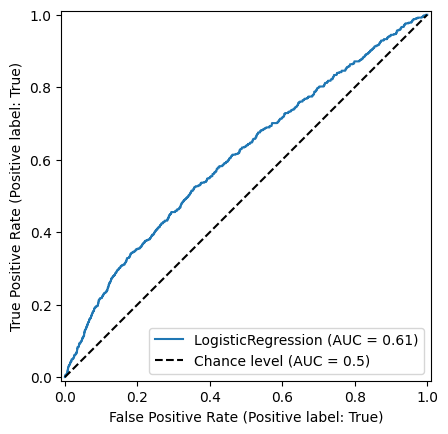

In [273]:
# ВАЖНО не используется кроссвалидационный анализ, результаты в пределах (0.5 - 0.62)
clf = LogisticRegression(**clf_params)
clf.fit(X_train,y_train)
RocCurveDisplay.from_estimator(clf,X_test,y_test, plot_chance_level=True)

### Значимость параметров
Рассмотрм значимость конечных гиперпараметров

In [274]:
#получаем средние важности коэффициентов кроссвалидацией (сохраняются в FeatureImportance.csv)
# crossValPermutationScore(clf_params)

features = pd.read_csv("FeatureImportance.csv")
#отсортируем важность признаков по убыванию
features.sort_values("importance", ascending=False)

,Unnamed: 0,feature,importance
0,0,sub_total,0.016042
1,1,time_delivered_день,0.000633
2,2,customer_id,0.000323
3,3,Date_Saturday,0.000300
4,4,delivery_time,0.000243
5,5,Date_Tuesday,0.000233
7,7,delivery_normal,0.000220
10,10,time_ordered_утро,0.000191
14,14,time_delivered_утро,0.000139
15,15,time_ordered_ночь,0.000133


Полученые коэффициенты являются усредненными значений коэффциентов кроссвалидацией и являются устойчивыми при условии дисбаланса классов
Исходя из полученных данных, можно увидеть, что наиболее значимым признаком является *цена заказываемого товара (sub_total)*, в то время как остальные данные настолько несущественны, что сопоставимы с шумом в данных

### Cнижение параметров
Убираем из модели незначимые параметры

#### Модель с жестким порогом параметров
Отберем для модели параметры, чья значимость оказалась выше 0.01

In [275]:
features[features.importance > 0.01].sort_values("importance", ascending=False)

,Unnamed: 0,feature,importance
0,0,sub_total,0.016042


In [276]:
#сохраням id покупателя в качестве индекса
dataset = delivery_data.set_index("customer_id")
#включаем значимые признаки
dataset = dataset[["sub_total", "refund"]]
dataset = pd.get_dummies(dataset)

X = dataset.drop("refund", axis=1)
Y = dataset["refund"]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25)

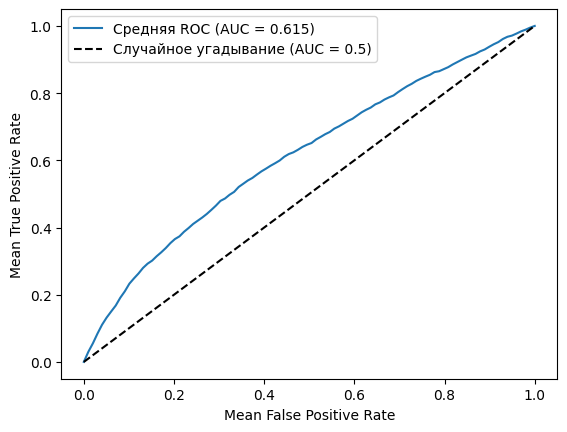

In [277]:
mean_fpr, mean_tpr, mean_auc, aucs = cross_val_roc__LR(clf_params)
plt.plot(mean_fpr, mean_tpr, label=f'Средняя ROC (AUC = {mean_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Случайное угадывание (AUC = 0.5)')

plt.xlabel("Mean False Positive Rate")
plt.ylabel("Mean True Positive Rate")

plt.legend()

##### Интепретация коэффициентов

In [278]:
clf = LogisticRegression(**clf_params)
clf.fit(X_train, y_train)

coef = pd.DataFrame(
    {"Feature":X_train.columns,
     "Coef":clf.coef_[0]})

coef.sort_values("Coef", ascending=False)

,Feature,Coef
0,sub_total,-11.868519


Исходя из результатов модели, повышение 1/sub_total (то есть при уменьшении реальной цены) шанс возврата значительно уменьшается

#### Модель с меньшим порогом параметров
Отберем для модели параметры, чья значимость оказалась выше 0.0001

In [279]:
features[features.importance > 0.0001].sort_values("importance", ascending=False)

,Unnamed: 0,feature,importance
0,0,sub_total,0.016042
1,1,time_delivered_день,0.000633
2,2,customer_id,0.000323
3,3,Date_Saturday,0.000300
4,4,delivery_time,0.000243
5,5,Date_Tuesday,0.000233
7,7,delivery_normal,0.000220
10,10,time_ordered_утро,0.000191
14,14,time_delivered_утро,0.000139
15,15,time_ordered_ночь,0.000133


In [280]:
#сохраням id покупателя в качестве индекса
dataset = delivery_data.set_index("customer_id")
#включаем значимые признаки
dataset = dataset[["sub_total", "Date", "time_delivered", "delivery_time", "delivery", "time_ordered", "refund"]]
dataset = pd.get_dummies(dataset)

X = dataset.drop("refund", axis=1)
Y = dataset["refund"]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25)

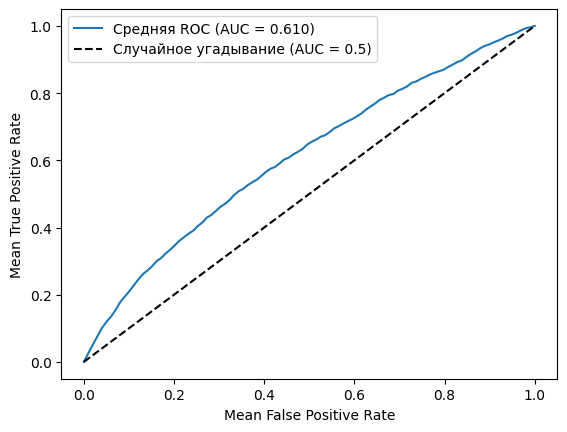

In [281]:
mean_fpr, mean_tpr, mean_auc, aucs = cross_val_roc__LR(clf_params)
plt.plot(mean_fpr, mean_tpr, label=f'Средняя ROC (AUC = {mean_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Случайное угадывание (AUC = 0.5)')

plt.xlabel("Mean False Positive Rate")
plt.ylabel("Mean True Positive Rate")

plt.legend()

При включении метрик дат, времени доставок и подобному среднее кроссвалидационное AUC качество модели ухудшилось на 0.005, что может быть как и шумом, так и реальным поведением модели. Однако прошлая модель имела схожую мощность, имея меньше параметров, что делает её предпочтительнее этой

## Дерево решений
Попробуем обучить дерево решений на обработанных данных и посмотреть кроссвалидационный ROC

In [ ]:
#Поиск оптимальных параметров модели деревьев решений
clf = DecisionTreeClassifier(random_state=42)
parameters = {"max_depth":range(1,10),"class_weight":["balanced",None]}
search = GridSearchCV(clf,param_grid=parameters)

[Text(0.5, 0.75, 'sub_total <= 0.006\ngini = 0.055\nsamples = 54229\nvalue = [52706, 1523]'),
 Text(0.25, 0.25, 'gini = 0.118\nsamples = 5645\nvalue = [5290, 355]'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.047\nsamples = 48584\nvalue = [47416, 1168]'),
 Text(0.625, 0.5, '  False')]

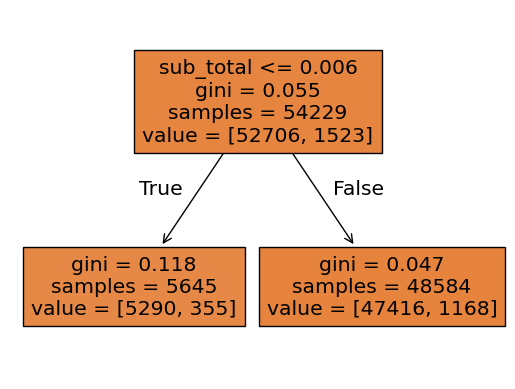

In [ ]:
search.fit(X_train, y_train)
plot_tree(search.best_estimator_,filled=True, feature_names=X_test.columns)

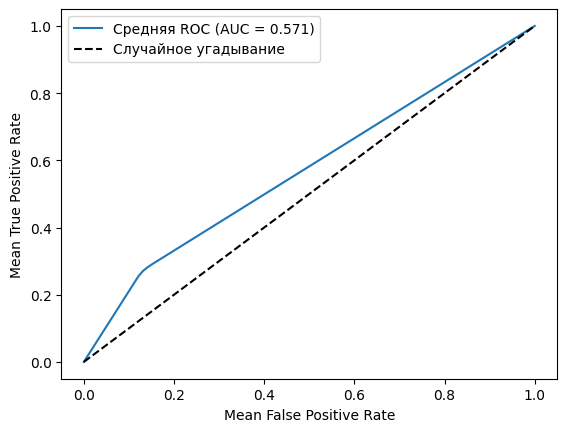

In [ ]:
mean_fpr, mean_tpr, mean_auc, aucs = cross_val_roc__DT(search.best_params_)
plt.plot(mean_fpr, mean_tpr, label=f'Средняя ROC (AUC = {mean_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Случайное угадывание')

plt.xlabel("Mean False Positive Rate")
plt.ylabel("Mean True Positive Rate")
plt.legend()

Дерево решений выделило единственный существенный признак - *цену товара (sub_total)*, что подтерждает наш кроссвалидационный тест логистической регрессии выше. AUC качество модели хуже логистической регресии при тех же параметрах

# Заключение

Исследование затронуло рассмотрение влияния различных метрик на вероятность возврата товара в сфере foodtech. Была проведена значительная работа с обработкой выросов, преоробразованием переменных, работой с дисбалансом классов.



Полученные модели несущественны для бизнеса, однако являются интересным исследованием для коллег в этой сфере.